In [1]:
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random


!pip install opencv-python

1.overlay함수를 통해 pos위치로부터 glasses 안경이미지를 영상에 합성해 줄 것입니다.
2.실제 합성을 수행할 부분 영상의 좌표를 계산해줍니다.

In [2]:
def overlay(img, glasses, pos):#pos위치부터 글래스이미지를 안경영상에 합성
    # 실제 합성을 수행할 부분 영상 좌표 계산
    sx = pos[0]#start x
    ex = pos[0] + glasses.shape[1] #glasses의 width와 height를 더한다.
    sy = pos[1]#start y
    ey = pos[1] + glasses.shape[0]  # glasses의 width와 height를 더한다.

    # 혹시나 합성할 영역이 입력 영상 크기를 벗어나면 무시
    if sx < 0 or sy < 0 or ex > img.shape[1] or ey > img.shape[0]:
        return

    # 부분 영상 참조. img1: 입력 영상의 부분 영상, img2: 안경 영상의 부분 영상
    img1 = img[sy:ey, sx:ex]   # shape=(h, w, 3)
    img2 = glasses[:, :, 0:3]  # shape=(h, w, 3) #0:3은 0,1,2번이다. BGR
    alpha = 1. - (glasses[:, :, 3] / 255.)  # shape=(h, w) 
    #3은 3번이다 알파채널. 가중치역할을 한다.
    #알파는 실수형 형태의 행렬이다.

    # BGR 채널별로 두 부분 영상의 가중합
    img1[..., 0] = (img1[..., 0] * alpha + img2[..., 0] * (1. - alpha)).astype(np.uint8)
    img1[..., 1] = (img1[..., 1] * alpha + img2[..., 1] * (1. - alpha)).astype(np.uint8)
    img1[..., 2] = (img1[..., 2] * alpha + img2[..., 2] * (1. - alpha)).astype(np.uint8)
    #BGR로 따로따로 연산을 하도록 한다.
    #타입만 적당히 지정해주자.

In [3]:
# 카메라 열기
cap = cv2.VideoCapture(0)
#카메라 오픈해서 Cap변수에 저장
if not cap.isOpened():
    print('Camera open failed!')
    sys.exit()

w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#기본적인 카메라의 프레임 크기 640x480이 보통 기본

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
#DIVX로 코덱을 사용
out = cv2.VideoWriter('output.avi', fourcc, 30, (w, h))
#output.avi 파일러 이름저장

# Haar-like XML 파일 열기
face_classifier = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')
#얼굴검출
eye_classifier = cv2.CascadeClassifier('haarcascade_eye.xml')
#눈검출 XML 파일

In [4]:
if face_classifier.empty() or eye_classifier.empty():
    print('XML load failed!')
    sys.exit()
#예외처리

# 안경 PNG 파일 열기 (Image from http://www.pngall.com/)
glasses = cv2.imread('glasses.png', cv2.IMREAD_UNCHANGED)
#채널이 네개로 되어있는 파일, 
#합성할 png파일

In [5]:
if glasses is None:
    print('PNG image open failed!')
    sys.exit()

In [6]:
ew, eh = glasses.shape[:2]  # 가로, 세로 크기
ex1, ey1 = 240, 300  # 왼쪽 눈 좌표
ex2, ey2 = 660, 300  # 오른쪽 눈 좌표
#합성할 안경영상의 눈위치 좌표. 
#왼쪽눈 좌표, 오른쪽눈의 좌표이며, 
#실제 검출안 눈과 거리와 상대적으로 거리를 맞춰줄 것이다.


In [7]:
# 매 프레임에 대해 얼굴 검출 및 안경 합성
while True:
    ret, frame = cap.read()
    #매 프레임마다 얼굴 검출
    if not ret:
        break

    # 얼굴 검출하는 함수, 속도조절하려고 값들 좀 수정, 디폴트로안하고
    faces = face_classifier.detectMultiScale(frame, scaleFactor=1.2,
                                             minSize=(100, 100), maxSize=(400, 400))
    
    for (x, y, w, h) in faces:
        #cv2.rectangle(frame, (x, y, w, h), (255, 0, 255), 2)

        # 눈 검출
        faceROI = frame[y:y + h // 2, x:x + w]
        eyes = eye_classifier.detectMultiScale(faceROI)

        # 눈을 2개 검출한 것이 아니라면 무시
        if len(eyes) != 2:
            continue

        # 두 개의 눈 중앙 위치를 (x1, y1), (x2, y2) 좌표로 저장
        x1 = x + eyes[0][0] + (eyes[0][2] // 2) #왼쪽눈의 가로크기
        y1 = y + eyes[0][1] + (eyes[0][3] // 2) #왼쪽눈의 세로크기
        x2 = x + eyes[1][0] + (eyes[1][2] // 2) #오른쪽눈의 가로크기
        y2 = y + eyes[1][1] + (eyes[1][3] // 2) #오른쪽눈의 세로크기
        #x하고 y는 얼굴 검출위치의 좌측상단인데 x,y는 얼굴 부분영상의 좌표이다.
        #얼굴검출한 위치에 눈검출한 위치를 더해야한다. 그래야 전체영상에서의 왼쪽눈 오른쪽눈을 계산할 수 있다.

        if x1 > x2:
            x1, y1, x2, y2 = x2, y2, x1, y1
        #왼쪽눈과 오른쪽눈 순서가 바뀔수있기때문에 오른쪽눈이 왼쪽눈보다 작으면 바꿔준다.

        #cv2.circle(faceROI, (x1, y1), 5, (255, 0, 0), 2, cv2.LINE_AA)
        #cv2.circle(faceROI, (x2, y2), 5, (255, 0, 0), 2, cv2.LINE_AA)

        # 두 눈 사이의 거리를 이용하여 스케일링 팩터를 계산 (두 눈이 수평하다고 가정)
        fx = (x2 - x1) / (ex2 - ex1)
        #실제 입력영상에서의 두눈의 좌표/ 안경영상에서의 두눈의 좌표 비율을 fx에 저장
        glasses2 = cv2.resize(glasses, (0, 0), fx=fx, fy=fx, interpolation=cv2.INTER_AREA)
        #보통 작아지는 형태로 바뀔것이다.

        # 크기 조절된 안경 영상을 합성할 위치 계산 (좌상단 좌표)
        #리사이즈한 png 영상이 실제 카메라 프레임 어느 위치부터 시작해서 합성을 할거냐를 pos에 저장
        pos = (x1 - int(ex1 * fx), y1 - int(ey1 * fx))

        # 영상 합성
        overlay(frame, glasses2, pos)
        #리사이즈된 안경영상을 합성. pos위치부터 합성

    # 프레임 저장 및 화면 출력
    out.write(frame)
    cv2.imshow('frame', frame)

    if cv2.waitKey(1) == 27:
        break

cap.release()
out.release()
cv2.destroyAllWindows()

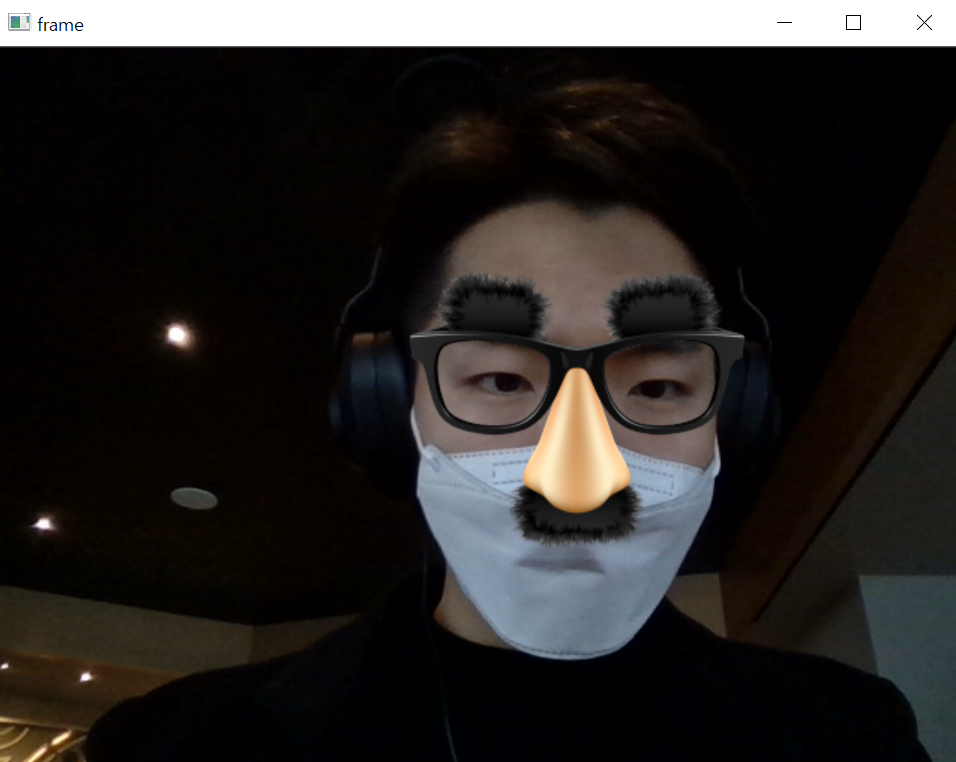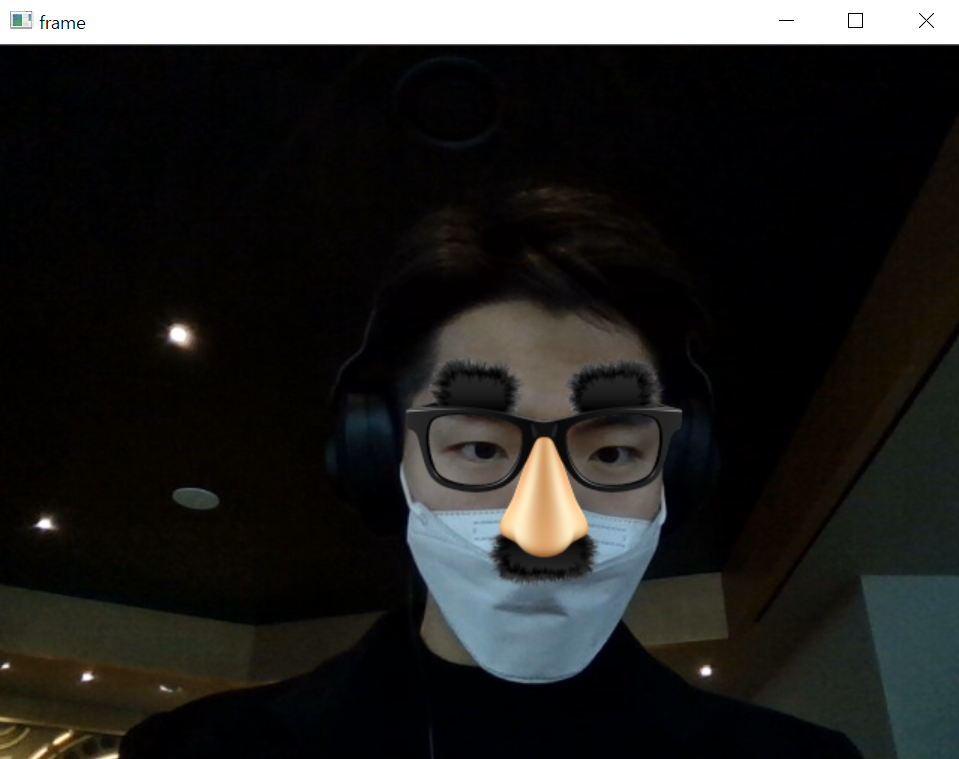